In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm
import copy

import gpytorch
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import george
from george import kernels

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import treegp

from lsst.meas.algorithms import CloughTocher2DInterpolatorUtils as ctUtils

%matplotlib widget

In [2]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect

        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print("time for %s = %.4f" % (fname, t1 - t0))
        return result

    return f2

In [ ]:
class GPRegressionModelKISS(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModelKISS, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. 
        # This util can help with that. Here we are using a grid that has 
        # the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to 
        # adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x, 1.0)
        print(grid_size)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class gp_torch():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
    
        self.hypers = {
            # 'likelihood.noise_covar.noise': torch.tensor(white_noise),
            'covar_module.base_kernel.lengthscale': torch.tensor(correlation_length),
            'covar_module.outputscale': torch.tensor(std),
        }
        # print('ok')
    @timer
    def fit(self, x, y):

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()# noise_constraint=gpytorch.constraints.GreaterThan(1e-15))
        self.model = GPRegressionModelKISS(x, y, self.likelihood)
        # self.model.initialize(**self.hypers)
        self.model.eval()
        self.likelihood.eval()

    @timer
    def predict(self, x):

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            prediction = self.likelihood(self.model(x))
            y_predict = prediction.mean
        return y_predict

class gp_sklearn():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):

        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    @timer
    def fit(self, x, y):
        alpha = self.white_noise**2
        self.kernel = self.std**2 * RBF(length_scale=self.l)
        self.gp =  GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, optimizer=None)
        self.gp.fit(x, y)

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred

class gp_george():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    @timer
    def fit(self, x, y):
        alpha = self.white_noise**2
        kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        self.gp.compute(x, yerr=alpha)
        self._y = y

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(self._y, x, return_var=False, return_cov=False)
        return y_pred


In [3]:
dic = pickle.load(open("data/out_test_0", "rb"))
maskedImage = dic['in']['maskedImage']

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(maskedImage.image.array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)

In [ ]:
block_size = 20

z = maskedImage.image.array[0:block_size,0:block_size]
y, x = np.indices(np.shape(z))
coordinates = np.array(([x.reshape(-1), y.reshape(-1)])).T

training_data_filter = maskedImage.mask.array[0:block_size,0:block_size] < 1
training_data_filter = training_data_filter.reshape(-1)
z_training = torch.tensor(z.reshape(-1)[training_data_filter])
coordinates_training = torch.tensor(coordinates[training_data_filter])
coordinates_val = torch.tensor(coordinates[~training_data_filter])

In [ ]:
gpt = gp_torch(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gpt.fit(coordinates_training, z_training)
z_validation = gpt.predict(coordinates_val)

In [ ]:
gps = gp_sklearn(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gps.fit(coordinates_training, z_training)
z_validation = gps.predict(coordinates_val)

In [ ]:
gpg = gp_george(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gpg.fit(coordinates_training, z_training)
z_validation = gpg.predict(coordinates_val)

In [ ]:
(2000 / 20) * (4000 / 20) * (0.0005 + 0.0009)

In [ ]:
40 * 80 * 0.05 / 60

In [ ]:
import numpy as np

def process_subarrays(arr, n):
    nx, ny = arr.shape
    for x in range(0, nx, n):
        for y in range(0, ny, n):
            sub_nx = min(n, nx - x)
            sub_ny = min(n, ny - y)
            sub_array = arr[x:x+sub_nx, y:y+sub_ny]
            # Process sub_array here
            print(arr)
            print("")
            print(sub_array)  # Example processing step
            print("")
            print("")

# Example usage
nx, ny = 10, 16  # Dimensions of the main array
n = 3  # Size of the sub-array
arr = np.arange(nx*ny).reshape(nx, ny)  # Create a 2D array for demonstration
process_subarrays(arr, n)

In [ ]:
bad, good = ctUtils.findGoodPixelsAroundBadPixels(maskedImage, ["BAD", "SAT", "CR", "EDGE"], buffer=15,)

In [ ]:
bad.shape

In [ ]:
good.shape

In [ ]:
A = maskedImage.getImage()
A.array.reshape(-1).shape

In [ ]:
442300 / 8552448

In [29]:
class GaussianProcessHODLRSolver():

    def __init__(self, variance=1., correlation_length=1., white_noise=0., mean=0.):
        
        self.variance = variance
        self.correlation_length = correlation_length
        self.white_noise  = white_noise
        self.mean = mean

    # @timer
    def fit(self, x_good):
        kernel = self.variance * kernels.ExpSquaredKernel(self.correlation_length, ndim=2)
        self.gp = george.GP(kernel, mean=self.mean,
                            fit_kernel=False,
                            solver=george.HODLRSolver, seed=42)
        self.gp.compute(x_good, yerr=self.white_noise)

    # @timer
    def predict(self, x_bad, y_good):
        y_pred = self.gp.predict(y_good, x_bad, return_var=False, return_cov=False)
        return y_pred


class gp_sklearn():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):

        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    def fit(self, x, y):
        alpha = self.white_noise**2
        self.kernel = self.std**2 * RBF(length_scale=self.l)
        self.gp =  GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, optimizer=None)
        self.gp.fit(x, y)

    def predict(self, x):
        y_pred = self.gp
        return y_pred


class gp_treegp():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise


    # @timer
    def fit(self, x, y):
        # alpha = self.white_noise**2
        # kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        # self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        # self.gp.compute(x, yerr=alpha)
        # self._y = y

        KERNEL = '%.2f**2 * RBF(%f)'%((self.std, self.l))
        self.gp = treegp.GPInterpolation(
                kernel=KERNEL,
                optimizer='none',
                normalize=True,
                p0=[3000.0, 0.0, 0.0],
                white_noise=self.white_noise,
        )
        self.gp.initialize(x, y)
        self.gp.solve()

    # @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred    
        

class InterpolateOverDefectGaussianProcess():

    @timer
    def __init__(self, maskedImage, defects=["BAD", "SAT", "CR", "EDGE"], fwhm=5, block_size=100, use_cholesky=True, use_HODLR=False):

        if use_cholesky and use_HODLR:
            raise ValueError("need to use Cholesky solver or HODLR")
        if use_cholesky:
            self.use_cholesky = True
        else:
            self.use_cholesky = False

        self.maskedImage = maskedImage
        self.defects = defects

        # Define hyperparameters for GPs.
        # Kernel would be isotropic RBF (simple / agnostic choice)
        # Amplitude of the kernel would be variance observed on the image.
        # Correlation lenght would be PSF size.
        # White noise would be standard deviation of the variance map.
        # Mean would be set to the mean in the whole CCD.
        # In order to do processing fast, sub-divide GP computation on a block.
        # Block shape is block_size * block_size

        # TO DO: compute the value only on good pixel
        # TO DO: deal with not good value?
        self.correlation_length = fwhm
        # self.white_noise = np.sqrt(np.mean(maskedImage.getVariance().array))
        # self.kernel_amplitude = np.var(maskedImage.getImage().array) - self.white_noise**2
        # self.mean = np.mean(maskedImage.getImage().array)
        self.block_size = block_size

    @timer
    def interpolate_over_defects(self):

        nx = self.maskedImage.getDimensions()[0]
        ny = self.maskedImage.getDimensions()[1]
        for x in tqdm(range(0, nx, self.block_size)):
            for y in range(0, ny, self.block_size):
                sub_nx = min(self.block_size, nx - x)
                sub_ny = min(self.block_size, ny - y)
                sub_masked_image = self.maskedImage[x:x+sub_nx, y:y+sub_ny]
                sub_masked_image = self.interpolate_sub_masked_image(sub_masked_image, treegp=self.use_cholesky)
                self.maskedImage[x:x+sub_nx, y:y+sub_ny] = sub_masked_image


    # @timer
    def interpolate_sub_masked_image(self, sub_masked_image, treegp=True):

        cut = self.correlation_length * 5
        bad_pixel, good_pixel = ctUtils.findGoodPixelsAroundBadPixels(sub_masked_image, self.defects, buffer=cut)
        # Do nothing if bad pixel is None.
        if np.shape(bad_pixel)[0] == 0:
            return sub_masked_image
        # Do GP interpolation if bad pixel found.
        else:
            # gp interpolation
            mean = np.mean(good_pixel[:,2:])
            white_noise = np.sqrt(np.mean(sub_masked_image.getVariance().array))
            kernel_amplitude = np.var(good_pixel[:,2:]) - white_noise*2

            if not treegp:
                print("George")
                gp_hodlr = GaussianProcessHODLRSolver(variance=kernel_amplitude, correlation_length=self.correlation_length,
                                                      white_noise=white_noise, mean=mean)
                gp_hodlr.fit(good_pixel[:,:2])
                gp_predict = gp_hodlr.predict(bad_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
            else:
                print("Treegp")
                gpt = gp_treegp(std=np.sqrt(kernel_amplitude), correlation_length=self.correlation_length, white_noise=white_noise)
                gpt.fit(good_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
                gp_predict = gpt.predict(bad_pixel[:,:2])
            bad_pixel[:,2:] = gp_predict.reshape(np.shape(bad_pixel[:,2:]))

            # update_value
            ctUtils.updateImageFromArray(sub_masked_image.image, bad_pixel)

            return sub_masked_image

In [33]:
to_interpolate = copy.deepcopy(maskedImage)

GP = InterpolateOverDefectGaussianProcess(to_interpolate, defects=["SAT"], fwhm=5, block_size=40, use_cholesky=True, use_HODLR=False)
GP.interpolate_over_defects()

time for InterpolateOverDefectGaussianProcess.__init__ = 0.0000


  6%|▌         | 3/52 [00:00<00:01, 29.79it/s]

Treegp
Treegp
Treegp


 38%|███▊      | 20/52 [00:00<00:00, 111.92it/s]

Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp


 62%|██████▏   | 32/52 [00:02<00:02,  9.24it/s] 

Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp
Treegp


100%|██████████| 52/52 [00:03<00:00, 16.88it/s]

Treegp
Treegp
Treegp
time for InterpolateOverDefectGaussianProcess.interpolate_over_defects = 3.0846


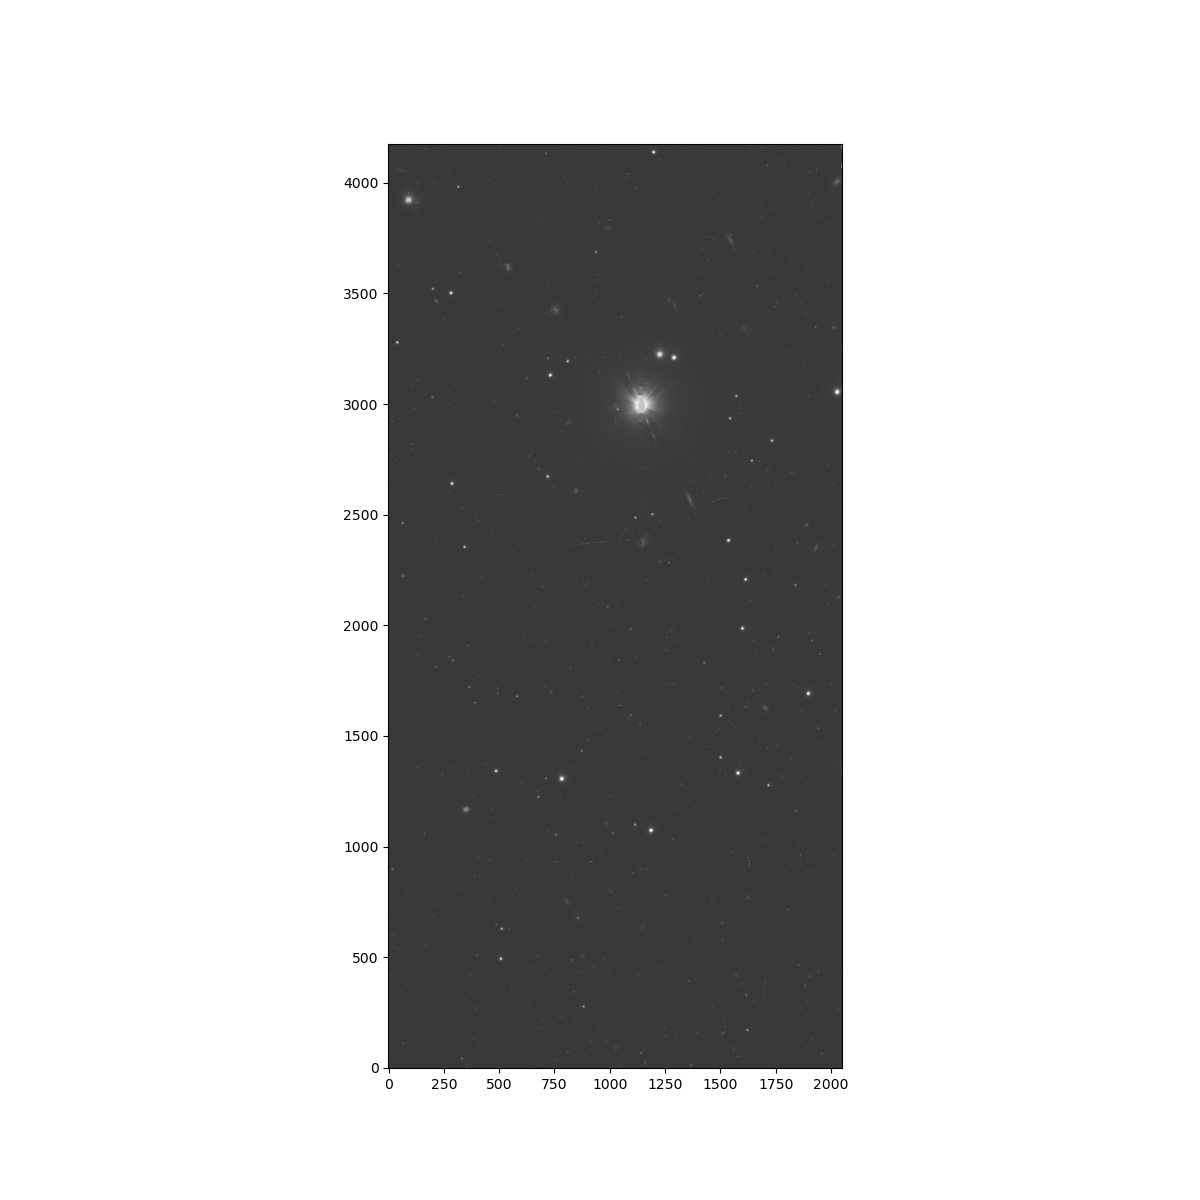

In [34]:
plt.figure(figsize=(12, 12))
#plt.imshow(GP.maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.imshow(GP.maskedImage.getImage().array, norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()

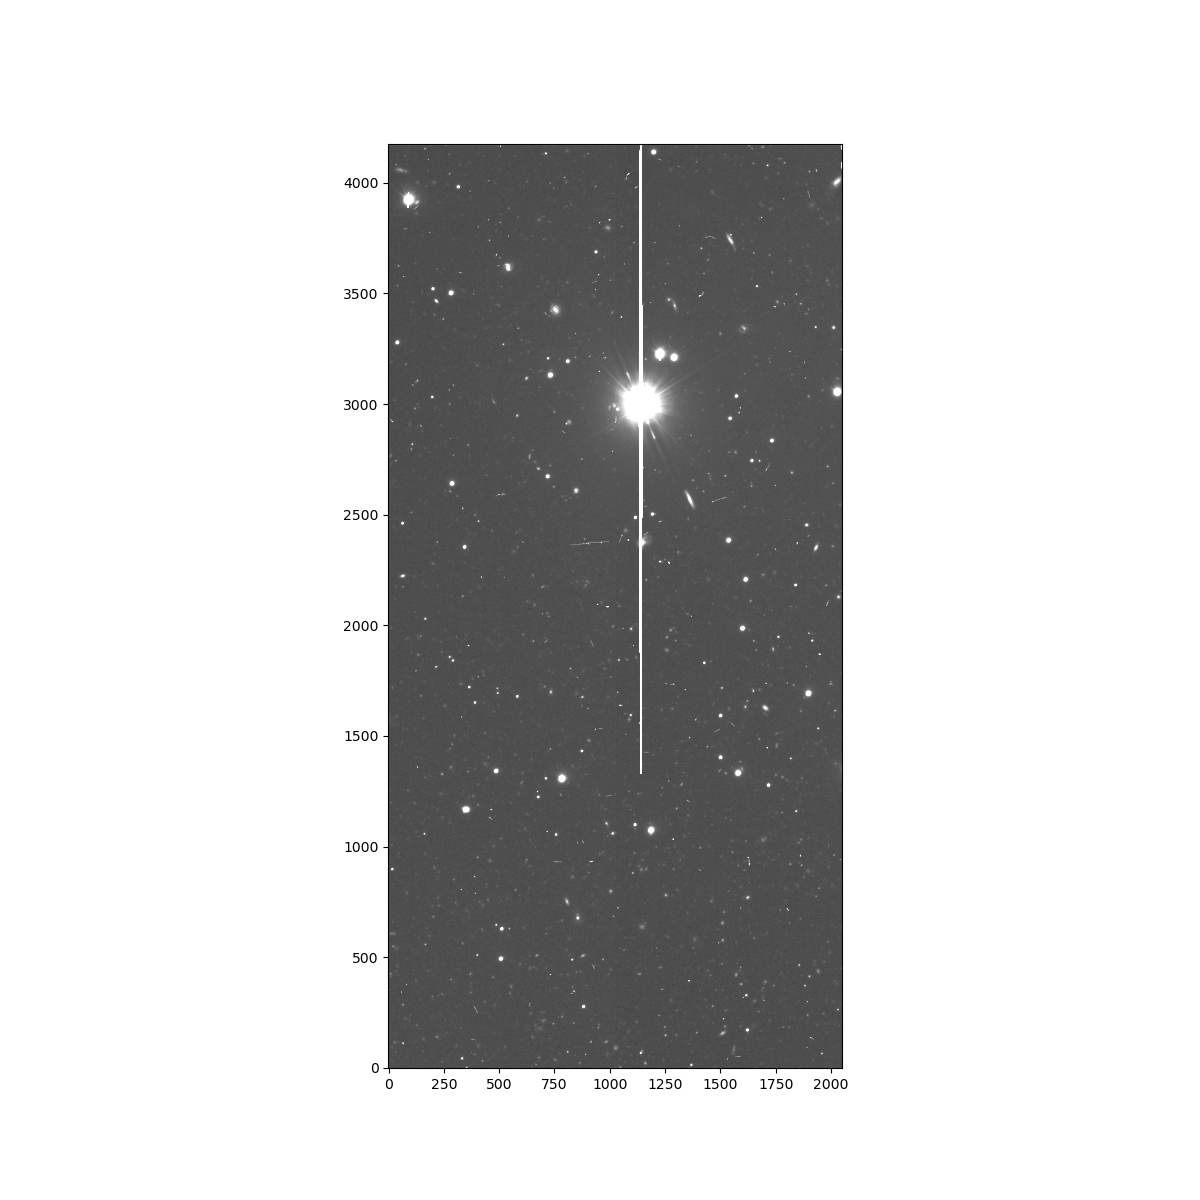

In [9]:
plt.figure(figsize=(12, 12))
plt.imshow(maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()

In [ ]:
GP.bad

In [ ]:
gpt = gp_sklearn(std=2, correlation_length=5, white_noise=4)
gpt.fit(GP.bad[:,:2], np.squeeze(GP.good[:,2:]))
gp_predict = gpt.predict(bad_pixel[:,:2])